In [14]:
import cv2
import albumentations as alb
import os
import pandas as pd 
import numpy as  np 
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv2D, Dense, Input, MaxPooling2D,
    LeakyReLU, BatchNormalization, 
    GlobalAveragePooling2D, Dropout,
    Flatten, PReLU, ReLU
)
from tensorflow.keras.models import  Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0

In [2]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [3]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [4]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, img_path, annotations, labels, batch_size, augment, img_shape, shuffle=True, training=True):
        self.img_paths = img_path 
        self.augment = augment
        self.annotations = annotations
        self.labels = labels
        self.indices = np.arange(len(img_path))
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        x = len(self.img_paths)//self.batch_size
        x += int((len(self.img_paths)%self.batch_size)!=0)
        return x
    
    def __getitem__(self, idx):
        batch_img_path = self.img_paths[self.indices[self.batch_size*idx: self.batch_size*(idx+1)]]
        batch_annotations = self.annotations[self.indices[self.batch_size*idx: self.batch_size*(idx+1)]]
        batch_labels = self.labels[self.indices[self.batch_size*idx: self.batch_size*(idx+1)]]
        batch_img, batch_annotations, batch_labels = self._data_generator(batch_img_path, batch_annotations, batch_labels)
        return batch_img, [batch_annotations, batch_labels]
#         return batch_img, batch_annotations
        
    
    def _data_generator(self, batch_img_path, batch_annotations, batch_labels):
        imgs = []
        annotations = []
        labels = []
        for num, (img_path, annotation, label) in enumerate(zip(batch_img_path, batch_annotations, batch_labels)):
            img = np.array(Image.open(img_path).convert('RGB'), dtype='float32')
            H, W, _ = img.shape
            x1 = (annotation[0]/W).astype('float32')
            y1 = (annotation[1]/H).astype('float32')
            x2 = (annotation[2]/W).astype('float32')
            y2 = (annotation[3]/H).astype('float32')
            annotations.append([x1, y1, x2, y2])
            labels.append(label)
            img = self.augment(image=img)['image']
            imgs.append(img)
        
        imgs = np.array(imgs)
        annotations = np.array(annotations)
        labels = np.array(labels)
        return imgs, annotations, labels
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [12]:
def Bounding_box(x):
    x = Dense(50, kernel_regularizer=l2(0.01))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.35)(x)
    x = Dense(25, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.35)(x)
    x = Dense(4, activation='sigmoid', name='bbx_out')(x)
    return x
    
def classifier(x, num_classes):
    x = Dense(50, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.35)(x)
    x = Dense(25, kernel_regularizer=l2(0.001))(x)
    x = LeakyReLU()(x)
    x = Dropout(0.35)(x)
    x = Dense(num_classes, activation='softmax', name='classifier_out')(x)
    return x

def ObjectDetection(img_shape, num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet'
    )
    head_model = base_model.output
    head_model = GlobalAveragePooling2D()(head_model)
    bbx_head = Bounding_box(head_model)
    classifier_head = classifier(head_model, num_classes)
    
    model = Model(inputs=base_model.input, outputs=[bbx_head, classifier_head])

    return model

In [18]:
# mean = (0, 0, 0)
# std = (1, 1, 1)

img_shape = (224, 224, 3)

train_augment = alb.Compose([
    alb.Normalize(max_pixel_value=255.0, always_apply=True),
    alb.Resize(img_shape[0], img_shape[1], always_apply=True),
])

val_augment = alb.Compose([
    alb.Normalize(max_pixel_value=255.0, always_apply=True),
    alb.Resize(img_shape[0], img_shape[1], always_apply=True),
])

In [19]:
master_image_folder = '101_ObjectCategories'
master_annotation_folder = 'Annotations'
image_classes = os.listdir(master_image_folder)
annotation_classes = os.listdir(master_annotation_folder)
classes = []

for class_ in image_classes:
    if class_ in annotation_classes:
        if len(os.listdir(master_image_folder + '/' + class_)) > 100 :
            classes.append(class_)


images_path = []
annotations = []
labels = []
for class_ in classes:
    class_image_folder  = master_image_folder + '/' + class_
    class_annotation_path  = master_annotation_folder + '/' + class_
    class_image_files = os.listdir(class_image_folder)
    for image_file in class_image_files:
        full_image_path = os.path.join(class_image_folder, image_file)
        labels.append(class_)
        full_annotation_path = class_annotation_path + '/annotation_' + image_file. split('_')[-1].split('.')[0] + '.mat'
        annotation = scipy.io.loadmat(full_annotation_path)['box_coord'][0]
        images_path.append(full_image_path)
        annotations.append([int(annotation[2]), int(annotation[0]), int(annotation[3]), int(annotation[1])])

images_path = np.array(images_path)
annotations = np.array(annotations)
labels = np.array(labels)
lb = LabelEncoder()
labels = lb.fit_transform(labels)

In [20]:
images_train, images_val, annotations_train, annotations_val, labels_train, labels_val = train_test_split(images_path, annotations, labels, test_size=0.1)

In [21]:
Epochs = 45
Batch_Size = 32
lr = 1e-3
optimizer = keras.optimizers.Adam(lr=1e-4)

In [22]:
train_loader = DataLoader(images_train, annotations_train, labels_train, Batch_Size, train_augment, img_shape)
val_loader = DataLoader(images_val, annotations_val, labels_val, Batch_Size, val_augment, img_shape)

In [23]:
img_shape = (224, 224, 3)
num_classes = len(classes)
model = ObjectDetection(img_shape, num_classes)
model.compile(
    loss={'bbx_out': 'huber', 'classifier_out': 'sparse_categorical_crossentropy'},
    optimizer=optimizer,
    metrics={'bbx_out': 'mse', 'classifier_out': 'sparse_categorical_accuracy'},
)

In [24]:
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//5)
    return lr
    
callbacks = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [25]:
model.fit(train_loader, epochs=Epochs, batch_size=Batch_Size, validation_data=(val_loader), callbacks=[callbacks])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/45
96/96 [==============================] - 20s 205ms/step - loss: 3.4284 - bbx_out_loss: 0.0703 - classifier_out_loss: 2.2494 - bbx_out_mse: 0.1406 - classifier_out_sparse_categorical_accuracy: 0.1776 - val_loss: 3.5436 - val_bbx_out_loss: 0.0665 - val_classifier_out_loss: 2.3855 - val_bbx_out_mse: 0.1330 - val_classifier_out_sparse_categorical_accuracy: 0.0947

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000208.
Epoch 2/45
96/96 [==============================] - 19s 200ms/step - loss: 1.6365 - bbx_out_loss: 0.0340 - classifier_out_loss: 0.7992 - bbx_out_mse: 0.0680 - classifier_out_sparse_categorical_accuracy: 0.7580 - val_loss: 2.3746 - val_bbx_out_loss: 0.0534 - val_classifier_out_loss: 1.7512 - val_bbx_out_mse: 0.1068 - val_classifier_out_sparse_categorical_accuracy: 0.4172

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000406.
Epoch 3/45
96/96 [=======================

96/96 [==============================] - 19s 195ms/step - loss: 0.1059 - bbx_out_loss: 0.0034 - classifier_out_loss: 0.0236 - bbx_out_mse: 0.0068 - classifier_out_sparse_categorical_accuracy: 0.9941 - val_loss: 2.3925 - val_bbx_out_loss: 0.0036 - val_classifier_out_loss: 2.3115 - val_bbx_out_mse: 0.0072 - val_classifier_out_sparse_categorical_accuracy: 0.3491

Epoch 00019: LearningRateScheduler reducing learning rate to 0.0005625000000000001.
Epoch 19/45
96/96 [==============================] - 19s 196ms/step - loss: 0.1053 - bbx_out_loss: 0.0035 - classifier_out_loss: 0.0252 - bbx_out_mse: 0.0069 - classifier_out_sparse_categorical_accuracy: 0.9941 - val_loss: 0.6178 - val_bbx_out_loss: 0.0028 - val_classifier_out_loss: 0.5392 - val_bbx_out_mse: 0.0055 - val_classifier_out_sparse_categorical_accuracy: 0.8402

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0005625000000000001.
Epoch 20/45
96/96 [==============================] - 19s 196ms/step - loss: 0.1063 - bbx_out_l

96/96 [==============================] - 19s 196ms/step - loss: 0.0672 - bbx_out_loss: 0.0030 - classifier_out_loss: 0.0110 - bbx_out_mse: 0.0060 - classifier_out_sparse_categorical_accuracy: 0.9977 - val_loss: 0.0797 - val_bbx_out_loss: 0.0020 - val_classifier_out_loss: 0.0249 - val_bbx_out_mse: 0.0041 - val_classifier_out_sparse_categorical_accuracy: 0.9970

Epoch 00037: LearningRateScheduler reducing learning rate to 0.000177978515625.
Epoch 37/45
96/96 [==============================] - 19s 195ms/step - loss: 0.0697 - bbx_out_loss: 0.0030 - classifier_out_loss: 0.0143 - bbx_out_mse: 0.0059 - classifier_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.1006 - val_bbx_out_loss: 0.0018 - val_classifier_out_loss: 0.0466 - val_bbx_out_mse: 0.0037 - val_classifier_out_sparse_categorical_accuracy: 0.9882

Epoch 00038: LearningRateScheduler reducing learning rate to 0.000177978515625.
Epoch 38/45
96/96 [==============================] - 19s 195ms/step - loss: 0.0679 - bbx_out_loss: 0.0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


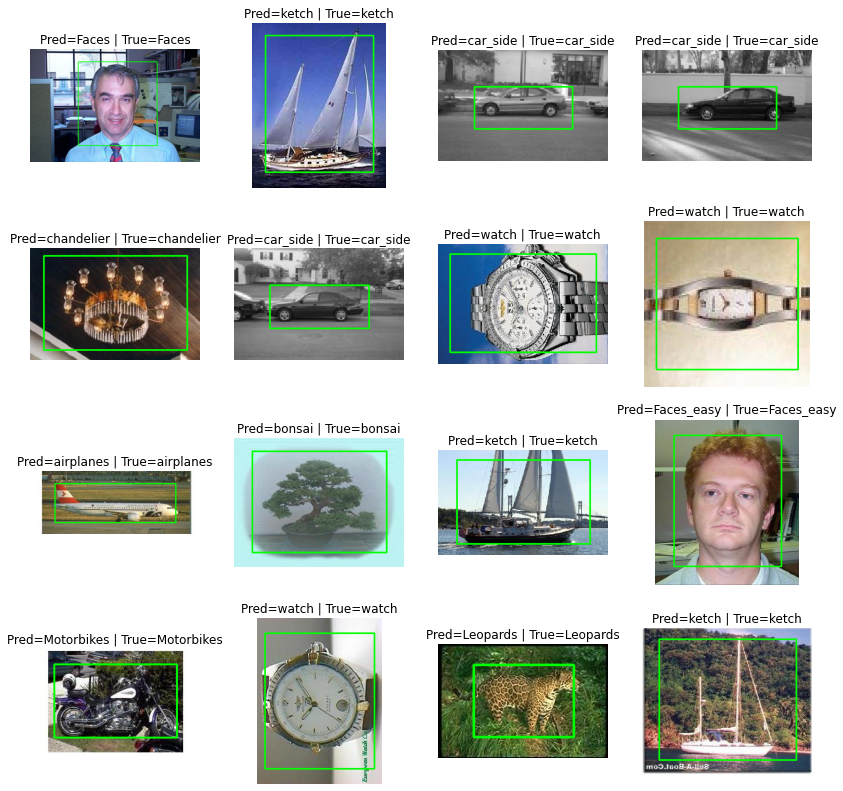

In [51]:
fig, axs = plt.subplots(4, 4, figsize=(14, 14))
for i in range(4):
    for j in range(4):
        class_idx = np.random.randint(0, len(classes))
        class_ = classes[class_idx]
        path = master_image_folder + '/' + class_
        image_files = os.listdir(path)
        image_idx = np.random.randint(0, len(image_files))
        image_path = os.path.join(path, image_files[image_idx])
        image = np.array(Image.open(image_path).convert('RGB'))
        H, W = image.shape[:2]
        image_ = val_augment(image=image)['image']
        image_ = image_[None, :, :, :]
        prediction = model.predict(image_)
        x1, y1, x2, y2 = prediction[0][0]
        label_prediction = prediction[1].argmax(-1)
        prediction_class = lb.inverse_transform([label_prediction])[0]
        x1 *= W
        y1 *= H
        x2 *= W
        y2 *= H
        img = cv2.imread(image_path)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].set_title(f'Pred={prediction_class} | True={class_}')
        axs[i, j].imshow(img)
        axs[i, j].axis('off')